# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)  Maximising Likelihood with Metropolis Hastings MCMC
Week 8 | Lesson 5.1

Markov Chain Monte Carlo (MCMC) is an efficient way to find the posterior distribution through Bayes Theorem as one sidesteps the cumbersome step of calculating the denominator of the equation $P(data)$.

To review, Bayes Theorem states:

### $$ P(\;hypothesis\;|\;data\;) = \frac{P(\;data\;|\;hypothesis\;)\;P(\;hypothesis\;) }{P(\;data\;)}$$

- $P(\;hypothesis\;|\;data\;)$ is the **posterior distribution of the hypothesis**
- $P(\;data\;|\;hypothesis\;)$ is the **likelihood of the data given the hypothesis**
- $P(\;data\;)$ is the **total probability of the data**, or the probability of the data occurring across all models
- $P(\;hypothesis\;)$ is the **prior distribution of the hypothesis**

Bayes Theorem will "update" our prior distribution to a posterior distribution, and both of those distributions are probability density functions. With $P(data)$, for example, we need to get the likelihood of the data across _all possible models_. With a coin flip, we can integrate between 0 and 1 for all possible weightings of the coin, but what about something more complicated like the number of minutes a flight is delayed? MCMC algorithms are designed to let us still get the posterior distribution estimate without needing to actually solve the equation.

In [1]:
from __future__ import print_function, division
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

### Load airline data

This dataset contains information on airports, year, and various metrics related to how delayed or not flights were.

In [2]:
air = pd.read_csv('./assets/datasets/airport_operations.csv')
air.columns = [c.replace(' ','_').replace('-','_') for c in air.columns]
air.head()

,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on_time_gate_departures,percent_on_time_airport_departures,percent_on_time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


Mean delay:  16.2499643282


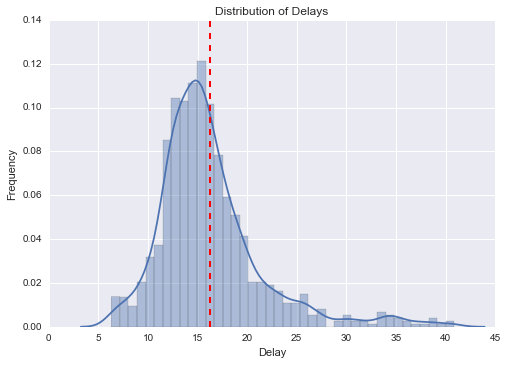

In [3]:
# Calculate the mean delay and plot the distribution of delays

delay = air["average_airport_departure_delay"].values
mean_delay = np.mean(delay)
print("Mean delay: ", mean_delay)
sns.distplot(delay, bins=40)
plt.axvline(mean_delay, lw=2, ls='dashed', color='r')
plt.title("Distribution of Delays")
plt.xlabel('Delay')
plt.ylabel('Frequency')
plt.show()

### Construct a prior belief distribution about possible delay times

Below I'm going to say that I believe flights are on average delayed 20 minutes. I will model my belief with a normal distribution and say that there is a 5 minute standard deviation around that 20 minute mean.

In [4]:
delay_belief_mean = 20
delay_belief_std = 5

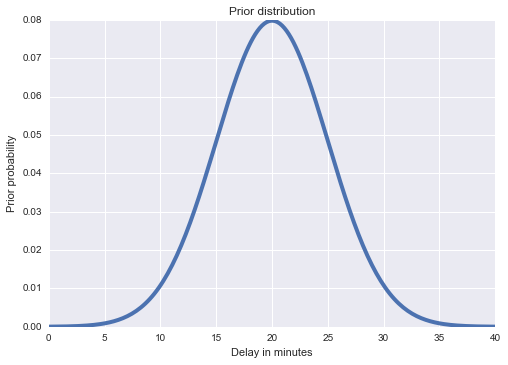

In [5]:
minute_range = np.linspace(0, 40, 200)
prior_pdf = stats.norm(delay_belief_mean, delay_belief_std).pdf(minute_range)
plt.plot(minute_range, prior_pdf, lw=4)
plt.title("Prior distribution")
plt.xlabel('Delay in minutes')
plt.ylabel('Prior probability')
plt.show()

### 'Log likelihood'

Recall that we have a component of Bayes Theorem that represents the likelihood of the data given our model:

### $$ P(data\;|\;model) $$

What is this representing? Our "model" in this case is the distribution of the possible mean delays. We are modeling delay times with a distribution of possible mean delay times and nothing more. It is not as complicated a model as a regression with multiple predictors, but a model nonetheless. To calculate the likelihood of the data given our model we need to ask: how likely would a datapoint (delay) be to occur according to our model?

Below we'll write a function to calculate the sum of the log of probability densities at each of our delay data points. This will be the aggregate likelihood across all the delays. Why the log of the probability densities? Often likelihoods are so small that the computer has a difficult time working with the numbers. Converting these to log format puts them in terms of orders of magnitude which are computationally easier to handle. As below we will be looking for the distribution shape parameters maximising the likelihood function, it is important to notice that taking the log will not change our estimate of these parameters.

In [6]:
# prior_mean is the distribution mean of our beliefs about delays
# prior_std is the standard deviation (scale) of that prior belief distribution
# the prior is Normal/Gaussian
# why do we return a sum instead of a product? because these are logs, and so the 
# product of the likelihood for each data point given the hypothesis becomes the sum

def log_likelihood_data(data, proposed_mean, proposed_std):
    distribution = stats.norm(proposed_mean, proposed_std)
    loglike = distribution.logpdf(data)
    return np.sum(loglike)

### Plot the log likelihood of the data given our current belief about mean and standard deviation of delays

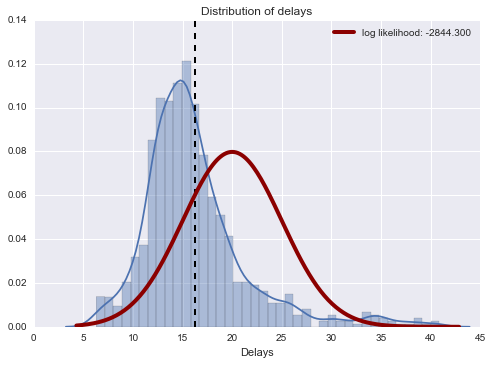

In [7]:
def plot_loglike_data(data, proposed_mean, proposed_std):
    sns.distplot(data, bins=40)
    plt.axvline(np.mean(data), lw=2, ls='dashed', color='black')
    proposal_xrange = np.linspace(np.min(data)-2, np.max(data)+2, 200)
    proposal_pdf = stats.norm(proposed_mean, proposed_std).pdf(proposal_xrange)
    loglike = log_likelihood_data(delay, proposed_mean, proposed_std)
    plt.plot(proposal_xrange, proposal_pdf, lw=4, color='darkred',
            label='log likelihood: '+'{0:.3f}'.format(loglike))
    plt.legend(loc='upper right')
    plt.xlabel("Delays")
    plt.title("Distribution of delays")
    plt.show()
    return

plot_loglike_data(delay, 20, 5)

### Intuition about log likelihoods

In [8]:
# intuition about log likelihoods: big negative numbers
# means really small likelihoods and the bigger 
# the absolute value, the smaller the likelihood

number1=0.0000000000000000000000000000000000000000000011
number2=0.0000000000000000000000000000000000000000000010
print("Log of small number:")
log_number1=np.log(number1)
print(log_number1)
print("Log of even smaller number has higher absolute value:")
log_number2=np.log(number2)
print(log_number2)

Log of small number:
-103.521019005
Log of even smaller number has higher absolute value:
-103.616329185


### Checking proposals about different delays

MCMC at the core is all about checking different likelihoods of the data for different versions of your model (different hypotheses). To clarify, we test against all data points as one update. What changes? The hypotheses, and we explore the hypothesis space as part of the MCMC algorithm. Right now we believe (our hypothesis is) that the mean delay is 20. How much would the likelihood $P\;(\;data\;|\;model\;)$ change if that mean were instead 30? Would this likelihood be larger or smaller?

We can use the likelihood function we wrote above to check any new parameter, but we need a system for making new proposals. In MCMC the parameter is moved at random in small increments. In this case we will draw a new number from a normal distribution with a mean that is our current value and small standard deviation. This will either move the distribution slightly to the left or to the right. For simplicity in this example we're only going to explore different possibilities for the mean and leave the standard deviation of the delay fixed, but really any parameter can be allowed to vary (but not the data itself).

In [9]:
# a function to get the distance for our next shift of the prior distribution:

def get_new_proposal(proposal_distribution_mean, proposal_distribution_std):
    prop_dist = stats.norm(proposal_distribution_mean, proposal_distribution_std)
    new_proposed_statistic = prop_dist.rvs()
    return new_proposed_statistic

### Plot a proposal shift from mean delay 20 to mean delay 30 - what is the new log likelihood?

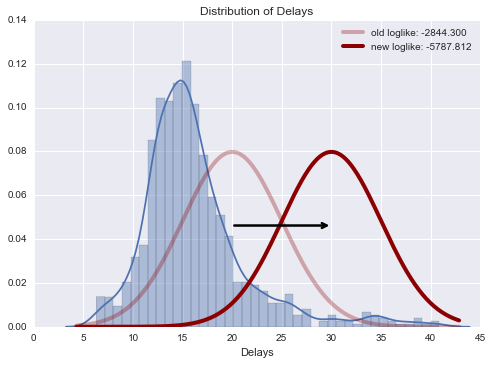

In [10]:
def plot_proposal_move(data, old_mean, old_std, new_mean, new_std):
    sns.distplot(data, bins=40)
    proposal_xrange = np.linspace(np.min(data)-2, np.max(data)+2, 200)
    old_pdf = stats.norm(old_mean, old_std).pdf(proposal_xrange)
    new_pdf = stats.norm(new_mean, new_std).pdf(proposal_xrange)
    old_loglike = log_likelihood_data(delay, old_mean, old_std)
    new_loglike = log_likelihood_data(delay, new_mean, new_std)
    plt.plot(proposal_xrange, old_pdf, lw=4, color='darkred', 
            alpha=0.3, label='old loglike: '+'{0:.3f}'.format(old_loglike))
    plt.plot(proposal_xrange, new_pdf, lw=4, color='darkred',
            label='new loglike: '+'{0:.3f}'.format(new_loglike))
    ylim = plt.ylim()
    plt.annotate('', (old_mean, ylim[1]*0.33), (new_mean, ylim[1]*0.33),
            arrowprops=dict(arrowstyle='<-', color="black", linewidth=2.5),
            xycoords='data', textcoords='data', color="black")
    plt.legend(loc='upper right')
    plt.title("Distribution of Delays")
    plt.xlabel("Delays")
    plt.show()
    return

plot_proposal_move(delay, 20, 5, 30, 5)

### Log likelihood of the prior - our P(hypothesis) term

We are also going to want to see how likely our new proposed mean is on our prior belief about the mean delays. For example, a mean delay of 100 minutes would be highly unlikely on our prior distribution of beliefs about how much flights can be delayed on average. We include both the information of our likelihood and our prior to form the posterior.

In [11]:
def log_likelihood_prior(statistic, prior_mean, prior_std):
    distribution = stats.norm(prior_mean, prior_std)
    stat_loglike = distribution.logpdf(statistic)
    return stat_loglike

### Plot the log likelihood of a delay of 30 minutes on our prior belief about mean delays

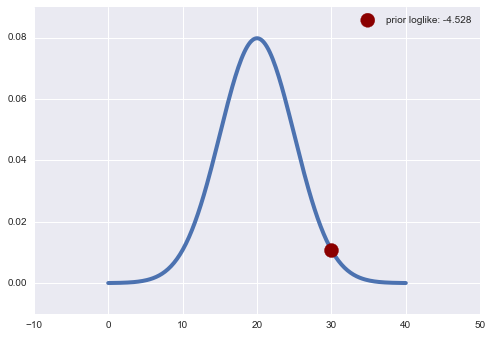

In [12]:
# this is a single point, representing the likelihood of a given
# hypothesis against the prior which was assumed a normal of mean 20 minutes

def plot_prior_loglike(proposed_mean, prior_mean, prior_std):
    x_range = np.linspace(0, 40, 200)
    prior_pdf = stats.norm(prior_mean, prior_std).pdf(x_range)
    proposed_p = stats.norm(prior_mean, prior_std).pdf(proposed_mean)
    prior_loglike = log_likelihood_prior(proposed_mean, prior_mean, prior_std)
    plt.plot(minute_range, prior_pdf, lw=4, zorder=2)
    plt.scatter(proposed_mean, proposed_p, color='darkred', s=200,
               label='prior loglike: '+'{0:.3f}'.format(prior_loglike),
               zorder=3)
    plt.legend(loc='upper right')
    plt.show()
plot_prior_loglike(30, 20, 5)

### Metropolis-Hastings sampler

Now we can actually start to do the core MCMC process. You've seen in pymc3 the NUTS sampler, which is a more advanced way of doing MCMC. We are going to use the original sampling process called Metropolis-Hastings as it is simpler. How do we avoid having to calculate the denominator in Bayes equation, $P(data)$?

Let's consider two different specific proposals for the mean delay, hypothesis1 and hypothesis2. We can write out the equations for the posterior probability of both when we consider those proposals against the data:

### $$ P(\;hypothesis_1\;|\;data\;) = \frac{P(\;data\;|\;hypothesis_1\;)}{P(\;data\;)}\;P(\;hypothesis_1\;) $$

### $$ P(\;hypothesis_2\;|\;data\;) = \frac{P(\;data\;|\;hypothesis_2\;)}{P(\;data\;)}\;P(\;hypothesis_2\;)  \ .$$

MCMC uses the idea that we can compare the _relative likelihoods_ of each hypothesis by dividing one by the other:

### $$ \frac{\frac{P(\;data\;|\;hypothesis_1\;)\;P(\;hypothesis_1\;)}{P(\;data\;)}}{\frac{P(\;data\;|\;hypothesis_2\;)\;P(\;hypothesis_2\;)}{P(\;data\;)}}  = \frac{P(\;data\;|\;hypothesis_1\;)\;P(\;hypothesis_1\;)}{P(\;data\;|\;hypothesis_2\;)\;P(\;hypothesis_2\;)}\  $$

This is the same as saying we are dividing the posterior of one of the hypotheses by the posterior of the other hypothesis. This cancels out the $P(data)$ component, so we do not have to compute it at all. But this doesn't get us all of the way there yet. The part that makes MCMC work for finding the posterior density is that it uses this equation above to _visit hypotheses with relatively higher likelihoods more often._ 

### The acceptance criterion:

Once you have the relative likelihood of the two hypotheses given the data, you can compare that to a random number between 0 and 1:

    acceptance_criterion = (proposal_likelihood / current_likelihood)
    or
    acceptance_criterion = exp(proposal_log_likelihood - current_log_likelihood)
    
    random_fraction = np.random.rand()  # lies between 0.0 and 1.0
    
    if acceptance_criterion > random_fraction:
        accept the proposed model
    else:
        accept the current model
        
If the proposed hypothesis has a _higher_ likelihood than the current hypothesis, the acceptance criterion will always be above one and it will always accept the proposed hypothesis as the new current hypothesis (i.e. mean value of the distribution, or whatever parameter you are testing). If the proposed hypothesis has a _lower_ likelihood than the current hypothesis, then it still has a chance of becoming the new current hypothesis with a probability proportional to relatively how much lower its likelihood is (hence randomness that encourages a fuller exploration of the hypothesis space).

In [13]:
def metropolis_sampler(data, current_mean, prior_mean, prior_std):
    current_data_loglike = log_likelihood_data(data, current_mean, prior_std)
    current_prior_loglike = log_likelihood_prior(current_mean, prior_mean, prior_std)
    proposed_mean = get_new_proposal(current_mean, 0.1)
    proposal_data_loglike = log_likelihood_data(data, proposed_mean, prior_std)
    proposal_prior_loglike = log_likelihood_prior(proposed_mean, prior_mean, prior_std)
    current_loglike = (current_data_loglike + current_prior_loglike)
    proposal_loglike = (proposal_data_loglike + proposal_prior_loglike)
    acceptance_criterion = np.exp(proposal_loglike - current_loglike)
    accept = (acceptance_criterion > np.random.rand())
    if accept:
        return proposed_mean
    else:
        return current_mean

### MCMC: Put it all together

For the final MCMC function, we just need to supply:

1. the data
2. the initial information about our model (in this case, the initial mean delay proposal)
3. the information about the prior distribution
4. the number of iterations

This master function will wrap the Metropolis-Hastings sampler and run it on each iteration. Recall that the sampler will return the current accepted hypothesis (the mean in this case). We append this to the list of posterior means and use it as the new current mean for the next iteration of the sampler (try re-reading the previous section on the Metropolis-Hastings sampler if this was not clear).

In [14]:
# We set a starting value here which is the initial_proposed_mean, generally you would
# try to find some sensible starting point based on the data but we just define it manually
# for simplicity

def markov_chain_monte_carlo(data, initial_proposed_mean, prior_mean, prior_std, iterations=1000):
    mean_posterior = [initial_proposed_mean]
    current_mean = initial_proposed_mean
    for i in range(iterations):
        if (i % 500) == 0:
            print('Iter:', i)
        current_mean = metropolis_sampler(data, current_mean, prior_mean, prior_std)
        mean_posterior.append(current_mean)
    print("Done")
    return mean_posterior

### Run MCMC on the delay data

In [15]:
posterior_mean_delay = markov_chain_monte_carlo(data=delay, initial_proposed_mean=10, prior_mean=20, 
                                                prior_std=5, iterations=5000)

Iter: 0
Iter: 500
Iter: 1000
Iter: 1500
Iter: 2000
Iter: 2500
Iter: 3000
Iter: 3500
Iter: 4000
Iter: 4500
Done


### Plot the posterior means

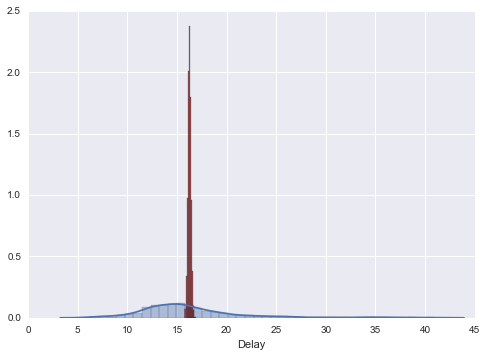

Blue is the original data, and red is the distribution of posterior means we found


In [16]:
sns.distplot(delay, bins=40)
plt.hist(posterior_mean_delay[2000:], color='darkred', alpha=0.6,  normed=True)
plt.xlabel('Delay')
plt.show()
print("Blue is the original data, and red is the distribution of posterior means we found")

In [17]:
# we return our maximum likelihood estimate
# of mean delay time - here I remove the first
# 1000 samples from consideration 

np.mean(posterior_mean_delay[2000:])

16.257698566096565

In [18]:
# Our mean delay time from the original data

print("Mean delay: ", mean_delay)

Mean delay:  16.2499643282


## Two dimensional case - mean and std

This is hence the end of the demonstration of the sampler for the one dimensional problem, but you might wonder what we have found out. We are looking for the best description of the data - the distribution that returns the maximum likelihood. In this case we assumed that was normal, and returned the best mean value we could find. That was because we wanted to seek a one dimensional problem for simplicity. Of course, a normal distribution is parameterised by both a mean and standard deviation and we saw yesterday the MCMC sampler testing both of these values to return posteriors for both.

In [19]:
# Now we implement things so we get a consideration of both mean and standard deviation

# in get_new_proposal_2 we implement a uniform distribution
# from which to sample the std, rather than the normal we set
# for the mean
def get_new_proposal_2(lower, upper):
    prop_dist = stats.uniform(lower, upper)
    new_proposed_statistic = prop_dist.rvs()
    return new_proposed_statistic

# we return now the log likelihood of both mean and std tested, which are summed
# rather than multiplied as we consider logs
def log_likelihood_prior_2(statistic,statistic2, prior_mean, prior_std,lower,upper):
    distribution_mean = stats.norm(prior_mean, prior_std)
    distribution_std = stats.uniform(lower, upper)
    stat_loglike = distribution_mean.logpdf(statistic) + distribution_std.logpdf(statistic2)
    return stat_loglike

# we perform the sampling and comparison of the combined log_likelihoods given the mean and std
# as a ratio of the current hypothesis pair to the proposed hypothesis pair (which is now a minus)
def metropolis_sampler_2(data, current_mean, current_std, prior_mean, prior_std,lower,upper):
    current_data_loglike = log_likelihood_data(data, current_mean, prior_std)
    current_prior_loglike = log_likelihood_prior(current_mean, prior_mean, prior_std)
    proposed_mean = get_new_proposal(current_mean, 0.1)
    proposed_std = get_new_proposal_2(lower,upper)
    proposal_data_loglike = log_likelihood_data(data, proposed_mean, proposed_std)
    proposal_prior_loglike = log_likelihood_prior_2(proposed_mean,proposed_std, prior_mean, prior_std,lower,upper)
    current_loglike = (current_data_loglike + current_prior_loglike)
    proposal_loglike = (proposal_data_loglike + proposal_prior_loglike)
    acceptance_criterion = np.exp(proposal_loglike - current_loglike)
    accept = (acceptance_criterion > np.random.rand())
    if accept:
        return proposed_mean, proposed_std
    else:
        return current_mean, current_std

# considering both mean and std posteriors
def markov_chain_monte_carlo_2(data, initial_proposed_mean, initial_proposed_std,
                               prior_mean, prior_std,lower,upper, iterations=1000):
    mean_posterior = [initial_proposed_mean]
    std_posterior = [initial_proposed_std]
    current_mean = initial_proposed_mean
    current_std = initial_proposed_std
    for i in range(iterations):
        if (i % 5000) == 0:
            print('Iter:', i)
        current_mean, current_std = metropolis_sampler_2(data, current_mean, current_std, 
                                          prior_mean, prior_std,lower,upper)
        mean_posterior.append(current_mean)
        std_posterior.append(current_std)
    print("Done")
    return mean_posterior, std_posterior

In [20]:
# this now requires more iterations to reach good results
# and you can see why pymc3 implements C to make this faster

posterior_mean_delay_2, posterior_std_delay_2 = markov_chain_monte_carlo_2(data=delay, 
                                                initial_proposed_mean=15, 
                                                initial_proposed_std=5,
                                                prior_mean=20, 
                                                prior_std=5,lower=1,
                                                upper=30,iterations=50000)

Iter: 0
Iter: 5000
Iter: 10000
Iter: 15000
Iter: 20000
Iter: 25000
Iter: 30000
Iter: 35000
Iter: 40000
Iter: 45000
Done


In [21]:
# return the mean values (after the first 10 000 samples are ignore)

np.mean(posterior_mean_delay_2[5000:]), np.mean(posterior_std_delay_2[5000:])

(16.251731539565498, 5.3583570717933338)

In [22]:
# these were the mean and std of the data (remember we might not expect to exactly
# return these values because we are explicitly defining a normal distribution)

np.mean(delay), np.std(delay)

(16.249964328180738, 5.3498282612071986)

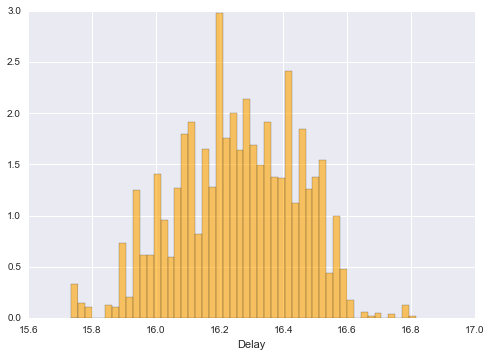

In [23]:
# to check sensible convergence we can see the distribution of mean samples

plt.hist(posterior_mean_delay_2[10000:], color='orange', alpha=0.6,  normed=True, bins=50)
plt.xlabel('Delay')
plt.show()

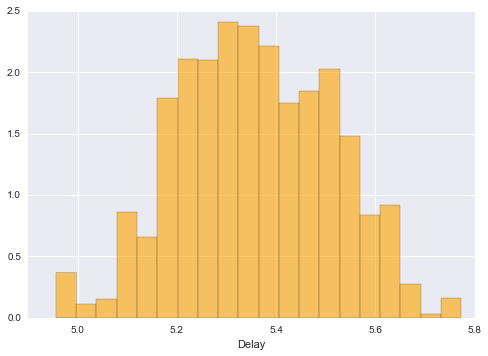

In [24]:
# and the distribution of std samples

plt.hist(posterior_std_delay_2[10000:], color='orange', alpha=0.6,  normed=True,bins=20)
plt.xlabel('Delay')
plt.show()

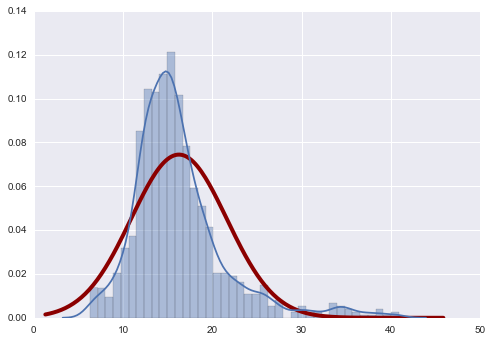

In [25]:
# Hence here is the maximum likelihood normal fit to the data we found

mean_=np.mean(posterior_mean_delay_2[5000:])
std_=np.mean(posterior_std_delay_2[5000:])
xrange_ = np.linspace(np.min(delay)-5, np.max(delay)+5, 200)
pdf_ = stats.norm(mean_, std_).pdf(xrange_)
plt.plot(xrange_, pdf_, lw=4, color='darkred')
sns.distplot(delay, bins=40)
plt.show()

Conclusion: we fit the maximum likelihood normal distribution to our data using Metropolis-Hastings Markov Chain Monte Carlo. Really make sure you followed all the steps on that. Once you are comfortable with it take a look back 
at yesterday's introduction and implement the solution in pymc3. Note you can overwrite the default NUTS sampler and implement Metropolis as an option within the model setting.